In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from xgboost import XGBClassifier 
from sklearn.ensemble import RandomForestClassifier
from collections import Counter

from sklearn.model_selection import  GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score, balanced_accuracy_score
RANDOM_STATE = 42

# load data

In [2]:
# X = np.load("balanced_features.npy")
# y = np.load("balanced_targets.npy")

X = np.load("Descriptor1_complete_features.npy")  
y = np.load("Descriptor1_complete_targets.npy")   

print(X.shape)

(1452, 147)


# class imbalance ratio

In [3]:
unique, counts = np.unique(y, return_counts=True)
for label, count in zip(unique, counts):
    print(f"Class {label}: {count} samples ({count/len(y):.2%})")

Class 0: 969 samples (66.74%)
Class 1: 483 samples (33.26%)


# identifying columns with >= 99 % zeros

In [4]:
# first 144 
X_eig = X[:, :144]

# how often each column is zero 
zero_rate = (X_eig == 0).mean(axis=0)
nonzero_count = (X_eig != 0).sum(axis=0)

# sorted summary (most-zero first)
order = np.argsort(-zero_rate)
summary = pd.DataFrame({
    "eig_col": order,                 # 0-based index within the 144 eig cols
    "zero_rate": zero_rate[order],
    "nonzero_count": nonzero_count[order]
})
print(summary.head(100).to_string(index=False))

# columns that are ≥99% zero
cols_99 = np.where(zero_rate >= 0.99)[0]
print("\nCols ≥99% zero (0-based):", cols_99.tolist())        #index start from 0 
#print("Cols ≥99% zero (1-based):", (cols_99 + 1).tolist())   #index start from 1 

 eig_col  zero_rate  nonzero_count
     143   0.999311              1
     128   0.999311              1
     129   0.999311              1
     130   0.999311              1
     131   0.999311              1
     132   0.999311              1
     133   0.999311              1
     134   0.999311              1
     142   0.999311              1
     136   0.999311              1
     137   0.999311              1
     138   0.999311              1
     139   0.999311              1
     140   0.999311              1
     141   0.999311              1
     135   0.999311              1
     112   0.998623              2
     113   0.998623              2
     114   0.998623              2
     115   0.998623              2
     116   0.998623              2
     117   0.998623              2
     118   0.998623              2
     121   0.998623              2
     120   0.998623              2
     122   0.998623              2
     123   0.998623              2
     124   0.998623 

# keeping top 72 + meta data (charge/spin/size)

In [5]:
# Eigenvalues + meta data 
K = 72 
X = np.hstack([X[:, :K], X[:, -3:]])

print( "Trimmed shape:", X.shape)

Trimmed shape: (1452, 75)


# train test split

In [6]:
# 20/80 split. 
# 20 % for our hold out test set 
# 80 % for hyperparam tuning, ...
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,        # preserve 66/34 balance
    random_state=RANDOM_STATE
)

print("Train/Val size:", X_trainval.shape[0])
print("Test size:", X_test.shape[0])

Train/Val size: 1161
Test size: 291


# XGB selecting k & params

In [7]:
RANDOM_STATE = 42

# neg = (y_trainval == 0).sum()
# pos = (y_trainval == 1).sum()
# spw = neg / max(pos, 1)

K_list = [5,6,7,8,9,10,11,12,13,14,15,16, 17, 18,19,20,22, 24,25, 30, 32,40,48,50,60,72]
K_list = list(range(1, 73))
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# search space 
param_dist = {
    "n_estimators": [200, 400, 600, 800, 1000],
    "max_depth": [3, 4, 5, 6, 8, 10],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "gamma": [0, 1, 5],
    "min_child_weight": [1, 3, 5],
}

# scoring metrics
scoring = {"bal_acc": "balanced_accuracy", "acc": "accuracy"}

results = []          # list of dicts per K
search_by_K = {}      # keep the fitted search object to reuse the winner's best_estimator_

for K in K_list:
    print(K)
    Xi = np.hstack([X_trainval[:, :K], X_trainval[:, -3:]]) #top k eigneval + 3 metadata
    xgb = XGBClassifier(random_state=RANDOM_STATE, 
                        eval_metric="logloss", 
                       # scale_pos_weight=spw
                       )
    search = RandomizedSearchCV(
        estimator=xgb,
        param_distributions=param_dist,
        n_iter=50,
        scoring=scoring,
        refit="bal_acc",
        cv=inner_cv,
        n_jobs=-1,
        random_state=RANDOM_STATE,
        verbose=0, 
    )
    search.fit(Xi, y_trainval)

    best_idx = search.best_index_
    splits = inner_cv.get_n_splits()

    # per-fold scores for std (balanced acc and accuracy)
    bal_folds = [search.cv_results_[f"split{i}_test_bal_acc"][best_idx] for i in range(splits)]
    acc_folds = [search.cv_results_[f"split{i}_test_acc"][best_idx]     for i in range(splits)]

    rec = {"K": K,
            "bal_mean": float(search.cv_results_["mean_test_bal_acc"][best_idx]),
            "bal_std":  float(np.std(bal_folds)),
            "acc_mean": float(search.cv_results_["mean_test_acc"][best_idx]),
            "acc_std":  float(np.std(acc_folds)),
            "best_params": search.best_params_,
    }
    results.append(rec)
    search_by_K[K] = search

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72


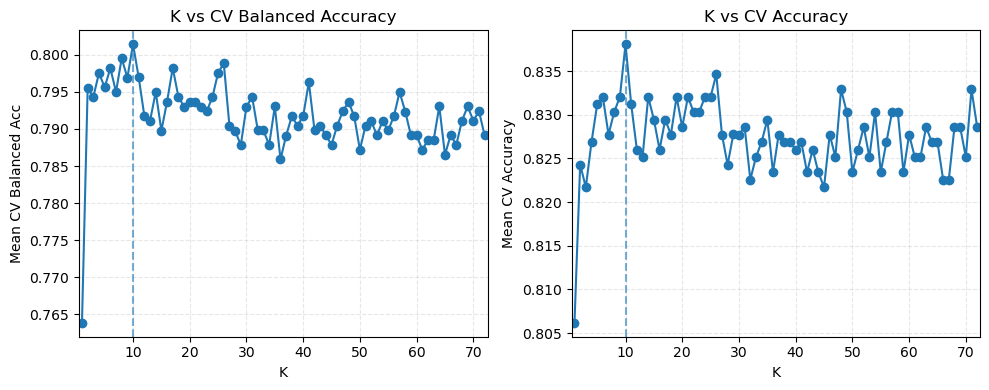

In [ ]:
df = pd.DataFrame(results).sort_values("K").reset_index(drop=True)

# Best K by balanced accuracy (tie-break: acc_mean, then smaller K)
best_rec = max(df.to_dict("records"), key=lambda d: (d["bal_mean"], d["acc_mean"], -d["K"]))
K_star = best_rec["K"]

# Plots: left = K vs CV Balanced Acc, right = K vs CV Accuracy (no std/error bars)
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True)

# Left: balanced accuracy
axes[0].plot(df["K"], df["bal_mean"], "o-")
axes[0].axvline(K_star, linestyle="--", alpha=0.6)
axes[0].set_title("K vs CV Balanced Accuracy")
axes[0].set_xlabel("K")
axes[0].set_ylabel("Mean CV Balanced Acc")
axes[0].grid(alpha=0.3, linestyle="--")

# Right: accuracy
axes[1].plot(df["K"], df["acc_mean"], "o-")
axes[1].axvline(K_star, linestyle="--", alpha=0.6)
axes[1].set_title("K vs CV Accuracy")
axes[1].set_xlabel("K")
axes[1].set_ylabel("Mean CV Accuracy")
axes[1].grid(alpha=0.3, linestyle="--")

#  x-limits to tested Ks
axes[1].set_xlim(df["K"].min() - 0.5, df["K"].max() + 0.5)

plt.tight_layout()
plt.show()

In [13]:
#  summary sorted by balanced accuracy
results.sort(key=lambda d: d["bal_mean"], reverse=True)

print("\n=== XGB RandomizedSearch (5-fold), per-K summary — sorted by balanced accuracy ===")
print(" K   bal_mean  bal_sd   acc_mean  acc_sd ")
for r in results:
    print(f"{r['K']:2d}   {r['bal_mean']:.3f}    {r['bal_std']:.3f}    "
          f"{r['acc_mean']:.3f}    {r['acc_std']:.3f}")

# best k 
best = max(results, key=lambda d: (d["bal_mean"], d["acc_mean"], -d["K"]))
K_star = best["K"]
winner = best

print(f"\n>>> Selected K* = {K_star} by BEST bal_acc "
      f"(best bal_acc={best['bal_mean']:.3f}±{best['bal_std']:.3f}; "
      f"acc_mean={best['acc_mean']:.3f}±{best['acc_std']:.3f})")
print("Winner params:", winner.get("best_params"))


=== XGB RandomizedSearch (5-fold), per-K summary — sorted by balanced accuracy ===
 K   bal_mean  bal_sd   acc_mean  acc_sd 
10   0.801    0.024    0.838    0.015
 8   0.800    0.026    0.830    0.020
26   0.799    0.027    0.835    0.018
17   0.798    0.031    0.829    0.025
 6   0.798    0.027    0.832    0.019
25   0.798    0.024    0.832    0.015
 4   0.798    0.033    0.827    0.022
11   0.797    0.025    0.831    0.013
 9   0.797    0.022    0.832    0.019
41   0.796    0.027    0.827    0.018
 5   0.796    0.023    0.831    0.016
 2   0.796    0.037    0.824    0.028
 7   0.795    0.027    0.828    0.019
57   0.795    0.024    0.830    0.017
14   0.795    0.024    0.832    0.015
18   0.794    0.026    0.828    0.019
 3   0.794    0.015    0.822    0.012
31   0.794    0.023    0.829    0.016
24   0.794    0.026    0.832    0.016
16   0.794    0.017    0.826    0.015
20   0.794    0.025    0.829    0.017
21   0.794    0.028    0.832    0.017
48   0.794    0.024    0.833    0.016


In [14]:
# Refit on all train/val with K* and evaluate on test 
X_trainval_k = np.hstack([X_trainval[:, :K_star], X_trainval[:, -3:]])
X_test_k     = np.hstack([X_test[:, :K_star],     X_test[:, -3:]])

best_xgb = search_by_K[K_star].best_estimator_   # already refit on all train/val by RandomizedSearchCV
best_xgb.fit(X_trainval_k, y_trainval)           #  re-fit 

# Train eval
y_pred_tr = best_xgb.predict(X_trainval_k)
y_prob_tr = best_xgb.predict_proba(X_trainval_k)[:, 1]
print("\n=== XGBoostTrain Set Performance ===")
print(classification_report(y_trainval, y_pred_tr, digits=3))
print("Train Accuracy:", accuracy_score(y_trainval, y_pred_tr))
print("Train Balanced Acc:", balanced_accuracy_score(y_trainval, y_pred_tr))
print("Train ROC-AUC:", roc_auc_score(y_trainval, y_prob_tr))
print("Train PR-AUC:", average_precision_score(y_trainval, y_prob_tr))

y_pred_te = best_xgb.predict(X_test_k)
y_prob_te = best_xgb.predict_proba(X_test_k)[:, 1]
print("\n=== XGBoost Test Set Performance ===")
print(classification_report(y_test, y_pred_te, digits=3))
print("Test Accuracy:", accuracy_score(y_test, y_pred_te))
print("Test Balanced Acc:", balanced_accuracy_score(y_test, y_pred_te))
print("Test ROC-AUC:", roc_auc_score(y_test, y_prob_te))
print("Test PR-AUC:", average_precision_score(y_test, y_prob_te))


=== XGBoostTrain Set Performance ===
              precision    recall  f1-score   support

           0      0.965     0.985     0.974       775
           1      0.968     0.927     0.947       386

    accuracy                          0.966      1161
   macro avg      0.966     0.956     0.961      1161
weighted avg      0.966     0.966     0.965      1161

Train Accuracy: 0.9655469422911284
Train Balanced Acc: 0.9559886344643156
Train ROC-AUC: 0.9947818819989972
Train PR-AUC: 0.9884579780160743

=== XGBoost Test Set Performance ===
              precision    recall  f1-score   support

           0      0.858     0.902     0.879       194
           1      0.782     0.701     0.739        97

    accuracy                          0.835       291
   macro avg      0.820     0.802     0.809       291
weighted avg      0.832     0.835     0.833       291

Test Accuracy: 0.8350515463917526
Test Balanced Acc: 0.8015463917525774
Test ROC-AUC: 0.8816292911042618
Test PR-AUC: 0.813489167

# feature importance

all features:  ['feat_0', 'feat_1', 'feat_2', 'feat_3', 'feat_4', 'feat_5', 'feat_6', 'feat_7', 'feat_8', 'feat_9', 'feat_10', 'feat_11', 'feat_12']

Top 20 features:
feat_12    0.1503
feat_11    0.1482
feat_10    0.0849
feat_6     0.0749
feat_3     0.0745
feat_1     0.0719
feat_7     0.0691
feat_5     0.0594
feat_9     0.0580
feat_0     0.0558
feat_2     0.0540
feat_4     0.0535
feat_8     0.0456
dtype: float32


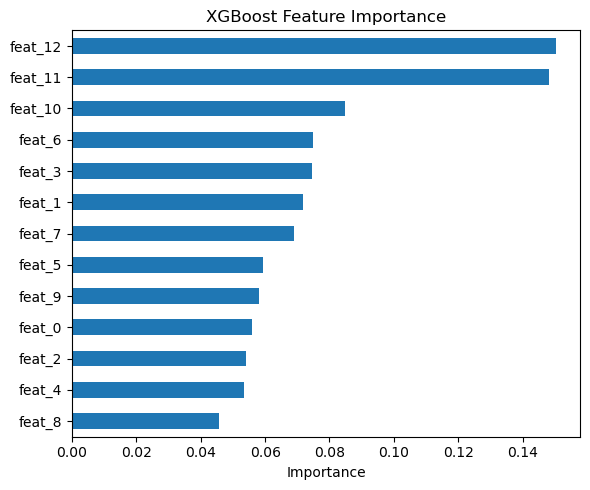

In [19]:
feat_names = [f"feat_{i}" for i in range(X_trainval_k.shape[1])]
print("all features: ", feat_names)

imp = pd.Series(best_xgb.feature_importances_, index=feat_names).sort_values(ascending=False)

print("\nTop 20 features:")
print(imp.head(20).round(4))

plt.figure(figsize=(6,5))
imp.head(20).iloc[::-1].plot(kind="barh")
plt.title("XGBoost Feature Importance")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

# RF selecting K & params

In [35]:
RANDOM_STATE = 42

K_list = [9,10,11]
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

param_dist = {                                  #add lr later
    "n_estimators": [200, 400, 600, 800, 1000],
    "max_depth": [None, 6, 10, 14],
    "min_samples_leaf": [1, 2, 5, 10],
    "min_samples_split": [2, 5, 10],
    "max_features": ["sqrt", "log2", 0.3, 0.5, 0.7],
    "bootstrap": [True],
    "class_weight": ["balanced", "balanced_subsample"],
}

# scoring 
scoring = {"bal_acc": "balanced_accuracy", "acc": "accuracy"}

results = []          # list of dicts per K
search_by_K = {}      # keep the fitted search object to reuse the winner's best_estimator_

for K in K_list:
    print(K)
    Xi = np.hstack([X_trainval[:, :K], X_trainval[:, -3:]])  # top-K eig + 3 metadata
    rf = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1)

    search = RandomizedSearchCV(
        estimator=rf,
        param_distributions=param_dist,
        n_iter=50,
        scoring=scoring,
        refit="bal_acc",
        cv=inner_cv,
        n_jobs=-1,
        random_state=RANDOM_STATE,
        verbose=0,
    )
    search.fit(Xi, y_trainval)

    best_idx = search.best_index_
    splits = inner_cv.get_n_splits()

    # per-fold scores for std (balanced acc and accuracy)
    bal_folds = [search.cv_results_[f"split{i}_test_bal_acc"][best_idx] for i in range(splits)]
    acc_folds = [search.cv_results_[f"split{i}_test_acc"][best_idx]     for i in range(splits)]

    rec = {"K": K,
            "bal_mean": float(search.cv_results_["mean_test_bal_acc"][best_idx]),
            "bal_std":  float(np.std(bal_folds)),
            "acc_mean": float(search.cv_results_["mean_test_acc"][best_idx]),
            "acc_std":  float(np.std(acc_folds)),
            "best_params": search.best_params_,}
            
    results.append(rec)
    search_by_K[K] = search


9
10
11


In [36]:
# Print summary sorted by balanced accuracy 
results.sort(key=lambda d: d["bal_mean"], reverse=True)

print("\n===  rf RandomizedSearch (5-fold), per-K summary — sorted by balanced accuracy ===")
print(" K   bal_mean  bal_sd   acc_mean  acc_sd   ")
for r in results:
    print(f"{r['K']:2d}   {r['bal_mean']:.3f}    {r['bal_std']:.3f}    "
          f"{r['acc_mean']:.3f}    {r['acc_std']:.3f}")

#  best k 
best = max(
    results,
    key=lambda d: (d["bal_mean"], d["acc_mean"], -d["K"])
)
K_star = best["K"]
winner = best

print(f"\n>>> Selected K* = {K_star} by BEST bal_acc "
      f"(bal_acc={best['bal_mean']:.3f}±{best['bal_std']:.3f}; "
      f"acc_mean={best['acc_mean']:.3f}±{best['acc_std']:.3f})")
print("Winner params:", winner.get("best_params"))



===  rf RandomizedSearch (5-fold), per-K summary — sorted by balanced accuracy ===
 K   bal_mean  bal_sd   acc_mean  acc_sd   
11   0.796    0.018    0.823    0.014
10   0.793    0.010    0.817    0.011
 9   0.792    0.015    0.819    0.012

>>> Selected K* = 11 by BEST bal_acc (bal_acc=0.796±0.018; acc_mean=0.823±0.014)
Winner params: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 0.7, 'max_depth': 10, 'class_weight': 'balanced', 'bootstrap': True}


In [37]:
# Refit on all train/val with K* and evaluate on test.
X_trainval_k = np.hstack([X_trainval[:, :K_star], X_trainval[:, -3:]])
X_test_k     = np.hstack([X_test[:, :K_star],     X_test[:, -3:]])

best_rf = search_by_K[K_star].best_estimator_   # already refit on all train/val by RandomizedSearchCV
best_rf.fit(X_trainval_k, y_trainval)           # (harmless re-fit to be explicit)

# Train eval
y_pred_tr = best_rf.predict(X_trainval_k)
y_prob_tr =best_rf.predict_proba(X_trainval_k)[:, 1]
print("\n=== Train Set Performance ===")
print(classification_report(y_trainval, y_pred_tr, digits=3))
print("Train Accuracy:", accuracy_score(y_trainval, y_pred_tr))
print("Train Balanced Acc:", balanced_accuracy_score(y_trainval, y_pred_tr))
print("Train ROC-AUC:", roc_auc_score(y_trainval, y_prob_tr))
print("Train PR-AUC:", average_precision_score(y_trainval, y_prob_tr))

# Test eval 
y_pred_te = best_rf.predict(X_test_k)
y_prob_te = best_rf.predict_proba(X_test_k)[:, 1]
print("\n=== Test Set Performance ===")
print(classification_report(y_test, y_pred_te, digits=3))
print("Test Accuracy:", accuracy_score(y_test, y_pred_te))
print("Test Balanced Acc:", balanced_accuracy_score(y_test, y_pred_te))
print("Test ROC-AUC:", roc_auc_score(y_test, y_prob_te))
print("Test PR-AUC:", average_precision_score(y_test, y_prob_te))


=== Train Set Performance ===
              precision    recall  f1-score   support

           0      0.983     0.966     0.975       775
           1      0.935     0.966     0.950       386

    accuracy                          0.966      1161
   macro avg      0.959     0.966     0.962      1161
weighted avg      0.967     0.966     0.967      1161

Train Accuracy: 0.9664082687338501
Train Balanced Acc: 0.9663864282132709
Train ROC-AUC: 0.995059334781882
Train PR-AUC: 0.9895330355028866

=== Test Set Performance ===
              precision    recall  f1-score   support

           0      0.878     0.856     0.867       194
           1      0.725     0.763     0.744        97

    accuracy                          0.825       291
   macro avg      0.802     0.809     0.805       291
weighted avg      0.827     0.825     0.826       291

Test Accuracy: 0.8247422680412371
Test Balanced Acc: 0.8092783505154639
Test ROC-AUC: 0.8646242958869168
Test PR-AUC: 0.7947454896110828
